In [4]:
#XGBoost
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek
from collections import Counter
import joblib
from sklearn.metrics import accuracy_score

# Load the dataset
data = pd.read_csv('final_dataset_10000.csv')

# Drop unnecessary columns
data = data.drop(['Conversion_Rate', 'Target_Audience'], axis=1)

# Convert 'Date' to datetime and extract useful features
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

# Drop the original 'Date' column
data = data.drop('Date', axis=1)

# Extract numeric part from the 'Duration' column and convert to integer
data['Duration'] = data['Duration'].str.extract('(\d+)').astype(int)

# Feature Engineering: Add interaction features
data['Engagement_Rate'] = data['Clicks'] / data['Impressions']
data['CPC'] = data['Ad_Budget'] / data['Clicks']

# Log transform skewed numeric features
data['Ad_Budget'] = np.log1p(data['Ad_Budget'])
data['Impressions'] = np.log1p(data['Impressions'])

# Encode categorical variables using Frequency Encoding
data['Ad_Type_encoded'] = data['Ad_Type'].map(data['Ad_Type'].value_counts(normalize=True))
data = data.drop('Ad_Type', axis=1)

# Define features and target
X = data.drop('Campaign_Type', axis=1)
y = data['Campaign_Type']

# Encode target variable
y_encoded = pd.factorize(y)[0]

# Apply SMOTE + Tomek Links for data balancing
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y_encoded)

# Scale numeric features
scaler = StandardScaler()
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
X_resampled[numeric_features] = scaler.fit_transform(X_resampled[numeric_features])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

# Initialize XGBoost with scale_pos_weight to handle class imbalance
xgb = XGBClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=5,
    scale_pos_weight=1,
    random_state=42
)

# Train the model
xgb.fit(X_train, y_train)

# Make predictions
y_pred = xgb.predict(X_test)

train_accuracy = accuracy_score(y_train, xgb.predict(X_train))
print(f"Training Accuracy: {train_accuracy:.2%}")

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save the model
joblib.dump(xgb, 'xgboost_improved.pkl')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:32:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Accuracy: 77.14%
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.37      0.41       900
           1       0.39      0.65      0.49       788
           2       0.46      0.37      0.41       905
           3       0.47      0.38      0.42       895

    accuracy                           0.44      3488
   macro avg       0.45      0.44      0.43      3488
weighted avg       0.45      0.44      0.43      3488

Confusion Matrix:
[[333 267 139 161]
 [ 82 513 119  74]
 [144 272 333 156]
 [151 272 131 341]]


['xgboost_improved.pkl']

In [ ]:
#XGBoost with trials
!pip install optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, PowerTransformer, PolynomialFeatures
from imblearn.over_sampling import ADASYN
import optuna
import joblib

# Load the dataset
data = pd.read_csv('final_dataset_10000.csv')

# Drop unnecessary columns
data = data.drop(['Conversion_Rate', 'Target_Audience'], axis=1)

# Convert 'Date' to datetime and extract useful features
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

# Drop the original 'Date' column
data = data.drop('Date', axis=1)

# Extract numeric part from the 'Duration' column and convert to integer
data['Duration'] = data['Duration'].str.extract('(\d+)').astype(int)

# Feature Engineering: Add interaction features
data['CTR'] = data['Clicks'] / data['Impressions']

# Log transform skewed numeric features using PowerTransformer
power = PowerTransformer(method='yeo-johnson', standardize=True)
data[['Ad_Budget', 'Impressions']] = power.fit_transform(data[['Ad_Budget', 'Impressions']])

# Encode categorical variables using One-Hot Encoding
data = pd.get_dummies(data, columns=['Ad_Type'], drop_first=True)

# Define features and target
X = data.drop('Campaign_Type', axis=1)
y = data['Campaign_Type']

# Encode target variable
y_encoded = pd.factorize(y)[0]

# Apply ADASYN for data balancing
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y_encoded)

# Add polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_resampled_poly = poly.fit_transform(X_resampled)

# Scale numeric features
scaler = StandardScaler()
X_resampled_poly = scaler.fit_transform(X_resampled_poly)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled_poly, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

# Define the objective function for Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 2),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'random_state': 42,
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10)
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Increase n_trials for better results

# Get the best parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train the model with the best parameters
best_xgb = XGBClassifier(**best_params, random_state=42)
best_xgb.fit(X_train, y_train)

# Make predictions
y_pred = best_xgb.predict(X_test)

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save the model
joblib.dump(best_xgb, 'xgboost_optuna_tuned.pkl')

[I 2025-03-01 23:57:52,644] A new study created in memory with name: no-name-3e3f26d0-3ed6-4689-986d-be33d79e5742
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:57:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-03-01 23:58:16,067] Trial 0 finished with value: 0.44724674232870953 and parameters: {'n_estimators': 377, 'learning_rate': 0.2697559926353863, 'max_depth': 6, 'colsample_bytree': 0.9913720075784987, 'subsample': 0.8355461977470955, 'gamma': 0.4333280889244218, 'reg_lambda': 1.948620949255711, 'reg_alpha': 0.6265868527721753, 'scale_pos_weight': 5.966694106417527}. Best is trial 0 with value: 0.44724674232870953.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:58:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-03-01 23:58:20,722] Trial 1 fin

Best Hyperparameters: {'n_estimators': 326, 'learning_rate': 0.235683544770401, 'max_depth': 10, 'colsample_bytree': 0.7184683859336424, 'subsample': 0.81164829577979, 'gamma': 0.009266631296792893, 'reg_lambda': 1.117529293341084, 'reg_alpha': 0.8576952783861111, 'scale_pos_weight': 7.522867606235091}
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.43      0.46      1168
           1       0.42      0.53      0.47      1201
           2       0.51      0.49      0.50      1195
           3       0.51      0.46      0.49      1194

    accuracy                           0.48      4758
   macro avg       0.48      0.48      0.48      4758
weighted avg       0.48      0.48      0.48      4758

Confusion Matrix:
[[502 309 188 169]
 [189 634 187 191]
 [168 269 590 168]
 [151 291 197 555]]


['xgboost_optuna_tuned.pkl']

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import joblib

# Load the dataset
data = pd.read_csv('final_dataset_3000.csv')

# Drop unnecessary columns
data = data.drop(['Conversion_Rate', 'Target_Audience'], axis=1)

# Convert 'Date' to datetime and extract useful features
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

# Drop the original 'Date' column
data = data.drop('Date', axis=1)

# Extract numeric part from the 'Duration' column and convert to integer
data['Duration'] = data['Duration'].str.extract('(\d+)').astype(int)

# Encode categorical variables
encoder = OneHotEncoder(drop='first', sparse_output=False)
categorical_columns = ['Ad_Type']
encoded_cats = encoder.fit_transform(data[categorical_columns])
encoded_cat_columns = encoder.get_feature_names_out(categorical_columns)
data = data.drop(categorical_columns, axis=1)
data[encoded_cat_columns] = encoded_cats

# Define features and target
X = data.drop('Campaign_Type', axis=1)
y = data['Campaign_Type']

# Encode target variable
y_encoded = pd.factorize(y)[0]

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42, k_neighbors=3)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

# Scale numeric features
scaler = StandardScaler()
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
X_resampled[numeric_features] = scaler.fit_transform(X_resampled[numeric_features])

# Define parameter grid for Grid Search
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [4, 5, 7],
    'min_samples_split': [15, 20],
    'min_samples_leaf': [8, 10],
    'max_features': ['sqrt'],
    'class_weight': ['balanced']
}

# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Initialize Grid Search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

# Train the model
grid_search.fit(X_resampled, y_resampled)

# Get the best model
best_model = grid_search.best_estimator_

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

# Make predictions
y_pred = best_model.predict(X_test)

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.47      0.56       361
           1       0.46      0.90      0.61       360
           2       0.66      0.51      0.57       361
           3       0.74      0.42      0.54       360

    accuracy                           0.57      1442
   macro avg       0.63      0.58      0.57      1442
weighted avg       0.63      0.57      0.57      1442

Confusion Matrix:
[[171 126  38  26]
 [ 17 323  16   4]
 [ 34 120 184  23]
 [ 31 136  42 151]]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import joblib

# Load the dataset
data = pd.read_csv('final_dataset_5000.csv')

# Drop unnecessary columns
data = data.drop(['Conversion_Rate', 'Target_Audience'], axis=1)

# Convert 'Date' to datetime and extract useful features
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

# Drop the original 'Date' column
data = data.drop('Date', axis=1)

# Extract numeric part from the 'Duration' column and convert to integer
data['Duration'] = data['Duration'].str.extract('(\d+)').astype(int)

# Encode categorical variables
encoder = OneHotEncoder(drop='first', sparse_output=False)
categorical_columns = ['Ad_Type']
encoded_cats = encoder.fit_transform(data[categorical_columns])
encoded_cat_columns = encoder.get_feature_names_out(categorical_columns)
data = data.drop(categorical_columns, axis=1)
data[encoded_cat_columns] = encoded_cats

# Define features and target
X = data.drop('Campaign_Type', axis=1)
y = data['Campaign_Type']

# Encode target variable
y_encoded = pd.factorize(y)[0]

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42, k_neighbors=3)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

# Scale numeric features
scaler = StandardScaler()
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
X_resampled[numeric_features] = scaler.fit_transform(X_resampled[numeric_features])

# Define a smaller parameter grid for Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10],
    'max_features': ['sqrt'],
    'class_weight': ['balanced']
}

# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize Grid Search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

# Train the model
grid_search.fit(X_resampled, y_resampled)

# Get the best model
best_model = grid_search.best_estimator_

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

# Make predictions
y_pred = best_model.predict(X_test)

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.98      0.64       601
           1       0.83      0.53      0.64       600
           2       0.79      0.57      0.66       601
           3       0.84      0.50      0.63       601

    accuracy                           0.65      2403
   macro avg       0.73      0.64      0.64      2403
weighted avg       0.73      0.65      0.64      2403

Confusion Matrix:
[[589   1   9   2]
 [214 317  40  29]
 [209  26 341  25]
 [215  40  43 303]]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import joblib

# Load the dataset
data = pd.read_csv('final_dataset_3000.csv')

# Drop unnecessary columns
data = data.drop(['Conversion_Rate', 'Target_Audience'], axis=1)

# Convert 'Date' to datetime and extract useful features
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

# Drop the original 'Date' column
data = data.drop('Date', axis=1)

# Extract numeric part from the 'Duration' column and convert to integer
data['Duration'] = data['Duration'].str.extract('(\d+)').astype(int)

# Encode categorical variables
encoder = OneHotEncoder(drop='first', sparse_output=False)
categorical_columns = ['Ad_Type']
encoded_cats = encoder.fit_transform(data[categorical_columns])
encoded_cat_columns = encoder.get_feature_names_out(categorical_columns)
data = data.drop(categorical_columns, axis=1)
data[encoded_cat_columns] = encoded_cats

# Define features and target
X = data.drop('Campaign_Type', axis=1)
y = data['Campaign_Type']

# Encode target variable
y_encoded = pd.factorize(y)[0]

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42, k_neighbors=3)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

# Scale numeric features
scaler = StandardScaler()
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
X_resampled[numeric_features] = scaler.fit_transform(X_resampled[numeric_features])

# Define a smaller parameter grid for Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10],
    'max_features': ['sqrt'],
    'class_weight': ['balanced']
}

# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize Grid Search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

# Train the model
grid_search.fit(X_resampled, y_resampled)

# Get the best model
best_model = grid_search.best_estimator_

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

# Make predictions
y_pred = best_model.predict(X_test)

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.70      0.78       361
           1       0.62      0.97      0.76       360
           2       0.85      0.72      0.78       361
           3       0.91      0.73      0.81       360

    accuracy                           0.78      1442
   macro avg       0.82      0.78      0.78      1442
weighted avg       0.82      0.78      0.78      1442

Confusion Matrix:
[[254  77  20  10]
 [  5 349   5   1]
 [ 16  70 261  14]
 [ 14  63  20 263]]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.combine import SMOTEENN  # Changed from SMOTE
from imblearn.over_sampling import SMOTE  # Added for SMOTE configuration
from collections import Counter
import joblib

# Load the dataset
data = pd.read_csv('final_dataset_3000.csv')

# Drop unnecessary columns
data = data.drop(['Conversion_Rate', 'Target_Audience'], axis=1)

# Convert 'Date' to datetime and extract useful features
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

# Drop the original 'Date' column
data = data.drop('Date', axis=1)

# Extract numeric part from the 'Duration' column and convert to integer
data['Duration'] = data['Duration'].str.extract('(\d+)').astype(int)

# Encode categorical variables
encoder = OneHotEncoder(drop='first', sparse_output=False)
categorical_columns = ['Ad_Type']
encoded_cats = encoder.fit_transform(data[categorical_columns])
encoded_cat_columns = encoder.get_feature_names_out(categorical_columns)
data = data.drop(categorical_columns, axis=1)
data[encoded_cat_columns] = encoded_cats

# Define features and target
X = data.drop('Campaign_Type', axis=1)
y = data['Campaign_Type']

# Encode target variable
y_encoded = pd.factorize(y)[0]

# Split data FIRST to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.3,
    random_state=42,
    stratify=y_encoded  # Maintain original class distribution
)

# Apply SMOTEENN only on training data
smt = SMOTEENN(
    smote=SMOTE(random_state=42, k_neighbors=3),  # Corrected: Pass SMOTE with k_neighbors
    random_state=42
)
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)

# Scale numeric features using training data statistics
scaler = StandardScaler()
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns

X_train_res[numeric_features] = scaler.fit_transform(X_train_res[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])  # Use same scaler

# Expanded hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Expanded range
    'max_depth': [5, 10, 15, None],  # Added more options
    'min_samples_split': [2, 5, 10],  # Added more granularity
    'min_samples_leaf': [1, 2, 5],  # Added more granularity
    'max_features': ['sqrt', 'log2'],  # Added 'log2'
    'class_weight': ['balanced', 'balanced_subsample', None]  # Experiment with class weights
}

# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize Grid Search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2  # Added for progress tracking
)

# Train the model on resampled training data
grid_search.fit(X_train_res, y_train_res)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate on untouched test data
y_pred = best_model.predict(X_test)

# Print classification report and confusion matrix
print("Optimized Classification Report:")
print(classification_report(y_test, y_pred))

print("Optimized Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save model components
joblib.dump(best_model, 'optimized_rf_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(encoder, 'encoder.pkl')

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Optimized Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.22      0.22       180
           1       0.00      0.00      0.00       360
           2       0.19      0.37      0.25       180
           3       0.23      0.48      0.31       180

    accuracy                           0.21       900
   macro avg       0.16      0.27      0.20       900
weighted avg       0.13      0.21      0.16       900

Optimized Confusion Matrix:
[[ 40   3  77  60]
 [ 85   0 130 145]
 [ 34   0  66  80]
 [ 27   1  66  86]]


['encoder.pkl']

Available Features in Original Dataset:
['Campaign_Type', 'Target_Audience', 'Duration', 'Ad_Type', 'Conversion_Rate', 'Ad_Budget', 'Reach', 'Clicks', 'Impressions', 'Date']
Available Features in Original Dataset:
['Campaign_Type', 'Duration', 'Ad_Budget', 'Reach', 'Clicks', 'Impressions', 'Year', 'Month', 'Day', 'Ad_Type_Facebook', 'Ad_Type_Google Ads', 'Ad_Type_Instagram', 'Ad_Type_Website', 'Ad_Type_YouTube']
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.70      0.78       361
           1       0.62      0.97      0.76       360
           2       0.85      0.72      0.78       361
           3       0.91      0.73      0.81       360

    accuracy                           0.78      1442
   macro avg       0.82      0.78      0.78      1442
weighted avg       0.82      0.78      0.78      1442


Top 10 Feature Importance with Standard Deviation:
               Feature  Importance       Std
1            Ad_Budget    0.1

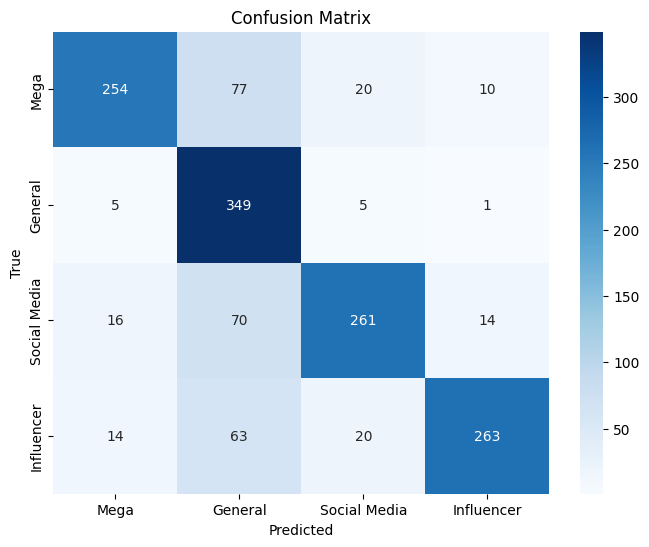

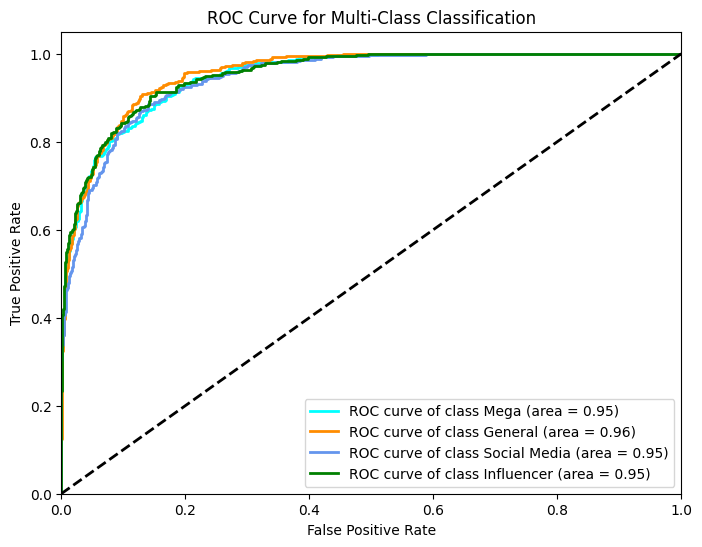

<ipython-input-4-5d2d90040848>:167: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(10), palette="viridis")


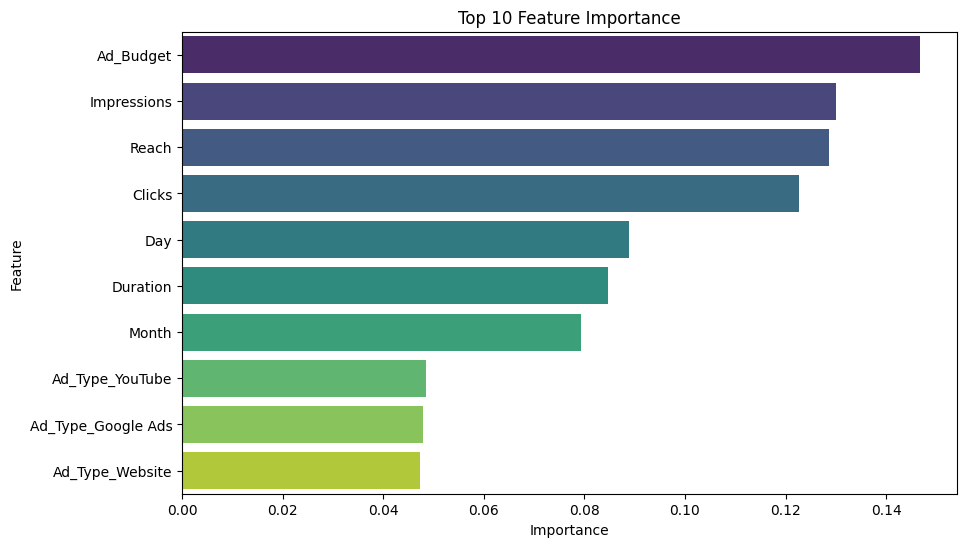

<ipython-input-4-5d2d90040848>:178: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_before, palette="Set2")
<ipython-input-4-5d2d90040848>:184: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_after, palette="Set2")


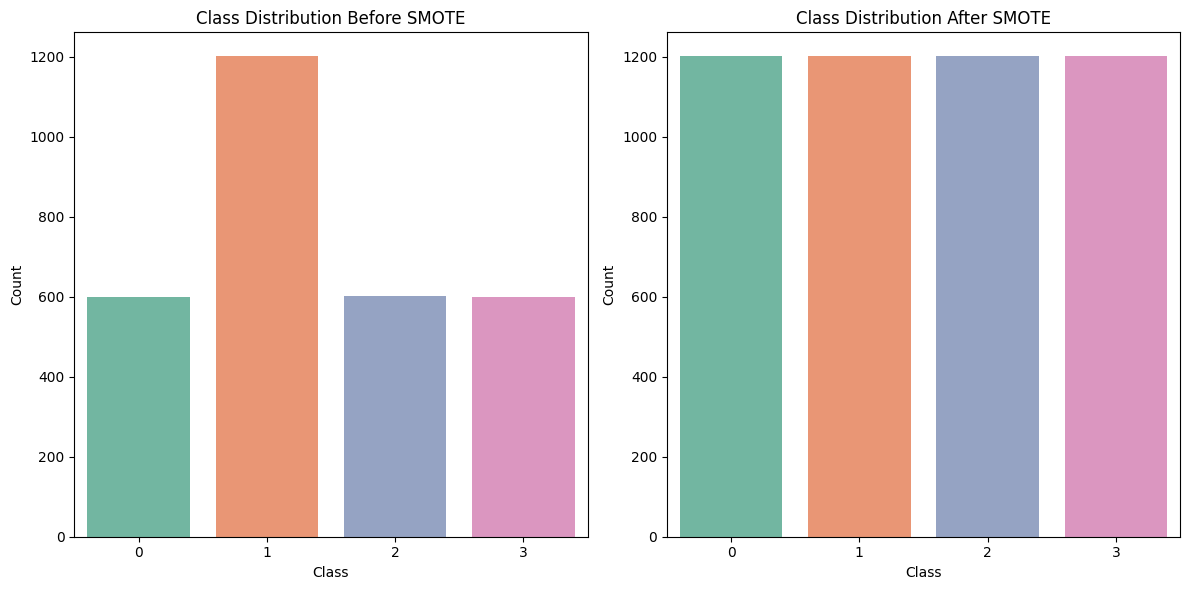

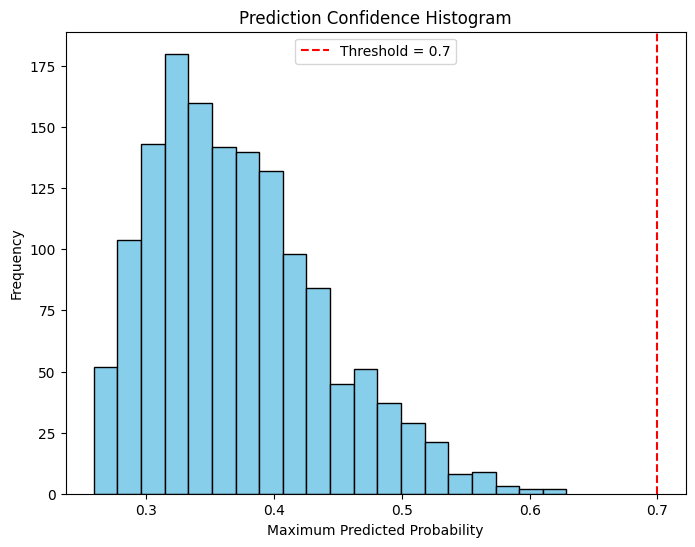

['standard_scaler.pkl']

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import joblib

# Load the dataset
data = pd.read_csv('final_dataset_3000.csv')

print("Available Features in Original Dataset:")
print(data.columns.tolist())

# Drop unnecessary columns
data = data.drop(['Conversion_Rate', 'Target_Audience'], axis=1)

# Convert 'Date' to datetime and extract useful features
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

# Drop the original 'Date' column
data = data.drop('Date', axis=1)

# Extract numeric part from the 'Duration' column and convert to integer
data['Duration'] = data['Duration'].str.extract('(\d+)').astype(int)

# Encode categorical variables
encoder = OneHotEncoder(drop='first', sparse_output=False)
categorical_columns = ['Ad_Type']
encoded_cats = encoder.fit_transform(data[categorical_columns])
encoded_cat_columns = encoder.get_feature_names_out(categorical_columns)
data = data.drop(categorical_columns, axis=1)
data[encoded_cat_columns] = encoded_cats

# Define features and target
X = data.drop('Campaign_Type', axis=1)
y = data['Campaign_Type']

# Encode target variable
y_encoded = pd.factorize(y)[0]

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42, k_neighbors=3)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

# Scale numeric features
scaler = StandardScaler()
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
X_resampled[numeric_features] = scaler.fit_transform(X_resampled[numeric_features])

# Define a smaller parameter grid for Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10],
    'max_features': ['sqrt'],
    'class_weight': ['balanced']
}

# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize Grid Search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

print("Available Features in Original Dataset:")
print(data.columns.tolist())

# Train the model
grid_search.fit(X_resampled, y_resampled)

# Get the best model
best_model = grid_search.best_estimator_

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

# Make predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate feature importance with uncertainty
importances = best_model.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in best_model.estimators_
], axis=0)

feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances,
    "Std": std
}).sort_values(by="Importance", ascending=False)

print("\nTop 10 Feature Importance with Standard Deviation:")
print(feature_importance_df.head(10))

# Print campaign type mapping
print("\nCampaign Type Mapping:")
print(dict(enumerate(data['Campaign_Type'].unique())))

# Perform cross-validation on the best model
cv_scores = cross_val_score(best_model, X_resampled, y_resampled, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

# Visualization Functions

# 1. Confusion Matrix Heatmap
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# 2. ROC Curve for Multi-Class Classification
def plot_roc_curve(y_true, y_pred_proba, class_names):
    y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
    n_classes = y_true_bin.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "green"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f"ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Multi-Class Classification")
    plt.legend(loc="lower right")
    plt.show()

# 3. Feature Importance Bar Plot
def plot_feature_importance(feature_importance_df):
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(10), palette="viridis")
    plt.title("Top 10 Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

# 4. Class Distribution Before and After SMOTE
def plot_class_distribution(y_before, y_after, title_before, title_after):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.countplot(x=y_before, palette="Set2")
    plt.title(title_before)
    plt.xlabel("Class")
    plt.ylabel("Count")

    plt.subplot(1, 2, 2)
    sns.countplot(x=y_after, palette="Set2")
    plt.title(title_after)
    plt.xlabel("Class")
    plt.ylabel("Count")

    plt.tight_layout()
    plt.show()

# 5. Prediction Confidence Histogram
def plot_confidence_histogram(y_pred_proba, confidence_threshold):
    max_proba = np.max(y_pred_proba, axis=1)
    plt.figure(figsize=(8, 6))
    plt.hist(max_proba, bins=20, color="skyblue", edgecolor="black")
    plt.axvline(x=confidence_threshold, color="red", linestyle="--", label=f"Threshold = {confidence_threshold}")
    plt.title("Prediction Confidence Histogram")
    plt.xlabel("Maximum Predicted Probability")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# Plot Confusion Matrix
class_names = list(data['Campaign_Type'].unique())
plot_confusion_matrix(y_test, y_pred, class_names)

# Plot ROC Curve
plot_roc_curve(y_test, y_pred_proba, class_names)

# Plot Feature Importance
plot_feature_importance(feature_importance_df)

# Plot Class Distribution Before and After SMOTE
plot_class_distribution(y_encoded, y_resampled, "Class Distribution Before SMOTE", "Class Distribution After SMOTE")

# Plot Prediction Confidence Histogram
confidence_threshold = 0.7
plot_confidence_histogram(y_pred_proba, confidence_threshold)

# Save the model, encoder, and scaler
joblib.dump(best_model, 'campaign_type_model.pkl')
joblib.dump(encoder, 'one_hot_encoder.pkl')
joblib.dump(scaler, 'standard_scaler.pkl')